In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW, lr_scheduler

from transformers import AutoModel, AutoTokenizer
from sklearn.model_selection import train_test_split
from collections import defaultdict
import time
import os
from tqdm import tqdm

In [2]:
from transformers import AutoModel, AutoTokenizer

model = AutoModel.from_pretrained('microsoft/deberta-base')  
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-base')

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [3]:
CONFIG = {
    'batch_size': 8,  
    'epochs': 5,
    'lr': 2e-5,
    'n_accumulate': 8,  
    'pretrained_model_path': 'microsoft/deberta-base',
    'weight_decay': 1e-6,
    'seed': 2022,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'patience': 3,  
    'saved_model_path': 'saved_model_state_deberta.pt'
}

In [4]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

# EDA

In [5]:
df_train['length_prompt'] = df_train['prompt'].str.len()
df_train['length_a'] = df_train['response_a'].str.len()
df_train['length_b'] = df_train['response_b'].str.len()
df_train['winner'] = 'tie'
df_train.loc[df_train['winner_model_a'] == 1, 'winner'] = 'a'
df_train.loc[df_train['winner_model_b'] == 1, 'winner'] = 'b'
df_train.loc[df_train['winner_tie'] == 1, 'winner'] = 'tie'
df_train['length_diff'] = df_train['length_a'] - df_train['length_b']

df_test['length_prompt'] = df_test['prompt'].str.len()
df_test['length_a'] = df_test['response_a'].str.len()
df_test['length_b'] = df_test['response_b'].str.len()
df_test['length_diff'] = df_test['length_a'] - df_test['length_b']

df_train['full_text'] = df_train[['prompt', 'response_a', 'response_b']].astype(str).apply(lambda x: ' '.join(x), axis=1)
df_test['full_text'] = df_test[['prompt', 'response_a', 'response_b']].astype(str).apply(lambda x: ' '.join(x), axis=1)

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57477 entries, 0 to 57476
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              57477 non-null  int64 
 1   model_a         57477 non-null  object
 2   model_b         57477 non-null  object
 3   prompt          57477 non-null  object
 4   response_a      57477 non-null  object
 5   response_b      57477 non-null  object
 6   winner_model_a  57477 non-null  int64 
 7   winner_model_b  57477 non-null  int64 
 8   winner_tie      57477 non-null  int64 
 9   length_prompt   57477 non-null  int64 
 10  length_a        57477 non-null  int64 
 11  length_b        57477 non-null  int64 
 12  winner          57477 non-null  object
 13  length_diff     57477 non-null  int64 
 14  full_text       57477 non-null  object
dtypes: int64(8), object(7)
memory usage: 6.6+ MB


In [7]:
df_train.describe()

,id,winner_model_a,winner_model_b,winner_tie,length_prompt,length_a,length_b,length_diff
count,5.747700e+04,57477.000000,57477.000000,57477.000000,57477.000000,57477.000000,57477.000000,57477.000000
mean,2.142564e+09,0.349079,0.341911,0.309011,369.198584,1377.818919,1386.162169,-8.343250
std,1.238327e+09,0.476683,0.474354,0.462090,1073.341472,1513.932333,1537.800488,1098.046783
min,3.019200e+04,0.000000,0.000000,0.000000,7.000000,4.000000,4.000000,-52573.000000
25%,1.071821e+09,0.000000,0.000000,0.000000,52.000000,408.000000,413.000000,-427.000000
50%,2.133658e+09,0.000000,0.000000,0.000000,96.000000,1076.000000,1086.000000,0.000000
75%,3.211645e+09,1.000000,1.000000,1.000000,243.000000,1862.000000,1873.000000,416.000000
max,4.294947e+09,1.000000,1.000000,1.000000,33056.000000,54058.000000,53830.000000,43542.000000


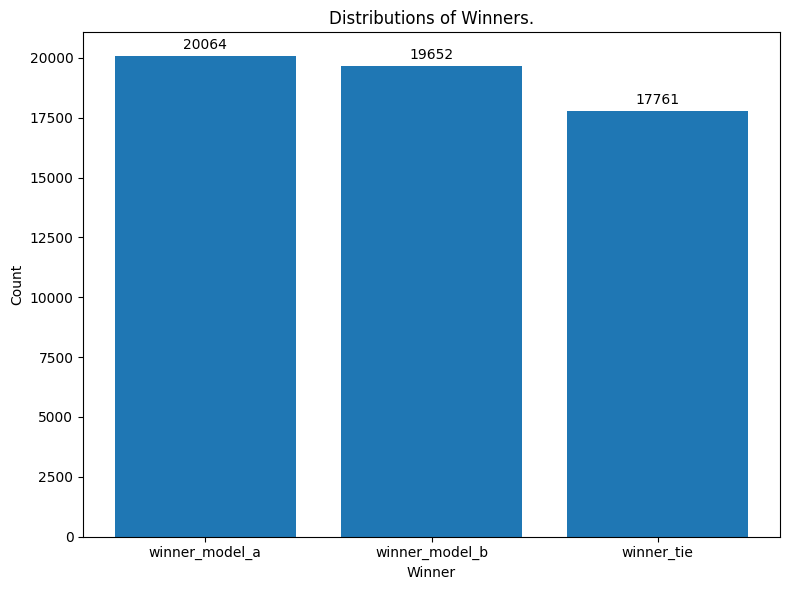

In [8]:
winner_count = df_train[['winner_model_a', 'winner_model_b', 'winner_tie']].sum().reset_index()
winner_count.columns = ['winner', 'count']

fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(winner_count['winner'], winner_count['count'])

ax.set_xlabel('Winner')
ax.set_ylabel('Count')
ax.set_title('Distributions of Winners.')

for bar in bars:
    height = bar.get_height()
    ax.annotate('{}'.format(height),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')
    
plt.tight_layout()
plt.show()

In [9]:
df_train.model_a.value_counts().head(10)

model_a
gpt-4-1106-preview            3678
gpt-3.5-turbo-0613            3553
gpt-4-0613                    3099
claude-2.1                    2859
gpt-4-0314                    2087
claude-instant-1              2085
claude-1                      1955
vicuna-33b                    1843
mixtral-8x7b-instruct-v0.1    1741
mistral-medium                1706
Name: count, dtype: int64

In [10]:
df_train.model_b.value_counts().head(10)

model_b
gpt-4-1106-preview            3709
gpt-3.5-turbo-0613            3530
gpt-4-0613                    3066
claude-2.1                    2724
claude-instant-1              2051
gpt-4-0314                    2035
claude-1                      2023
vicuna-33b                    1877
mixtral-8x7b-instruct-v0.1    1804
llama-2-70b-chat              1753
Name: count, dtype: int64

In [11]:
df = pd.DataFrame()
df['name'] = df_train['model_b'].unique()

lst_win = []
for i in df_train['model_b'].unique():
    filtered_rows_a = df_train[(df_train['model_a'] == i) & (df_train['winner_model_a'] == 1)]
    filtered_rows_b = df_train[(df_train['model_b'] == i) & (df_train['winner_model_b'] == 1)]
    count_rows = len(filtered_rows_a) + len(filtered_rows_b)
    lst_win.append(count_rows)
    
df['total_win'] = lst_win
df['win_rate'] = [i/len(df_train) for i in lst_win]
df.sort_values('win_rate', ascending=False)

,name,total_win,win_rate
19,gpt-4-1106-preview,4073,0.070863
0,gpt-4-0613,2450,0.042626
7,gpt-3.5-turbo-0613,2381,0.041425
4,gpt-4-0314,1993,0.034675
23,claude-1,1747,0.030395
...,...,...,...
21,chatglm2-6b,73,0.001270
60,openchat-3.5-0106,63,0.001096
61,qwen1.5-7b-chat,51,0.000887
49,qwen1.5-4b-chat,35,0.000609


In [12]:
fig = px.histogram(df_train, x = df_train['prompt'].str.len(), marginal = 'box', title  = 'Histogram of prompt text length', color_discrete_sequence = ["#FFA200"] )
fig.update_layout(bargap = 0.2)
fig.update_layout(font = dict(family = 'PT Sans', size = 19, color = "#C4FEFF"  ) )
fig.show()

In [13]:
fig = px.histogram(df_train, x = df_train['response_a'].str.len(), marginal = 'box', title  = 'Histogram of response_a text length', color_discrete_sequence = ["#FFA200"] )
fig.update_layout(bargap = 0.2)
fig.update_layout(font = dict(family = 'PT Sans', size = 19, color = "#C4FEFF"  ) )
fig.show()

In [14]:
fig = px.histogram(df_train, x = df_train['response_b'].str.len(), marginal = 'box', title  = 'Histogram of response_b text length', color_discrete_sequence = ["#FFA200"] )
fig.update_layout(bargap = 0.2)
fig.update_layout(font = dict(family = 'PT Sans', size = 19, color = "#C4FEFF"  ) )
fig.show()

In [15]:
fig = px.histogram(df_train, x = df_train['full_text'].str.len(), marginal = 'box', title  = 'Histogram of full_text text length', color_discrete_sequence = ["#FFA200"] )
fig.update_layout(bargap = 0.2)
fig.update_layout(font = dict(family = 'PT Sans', size = 19, color = "#C4FEFF"  ) )
fig.show()

In [16]:
fig = px.histogram(df_train, x = df_train['length_diff'], marginal = 'box', title  = 'Histogram of length_diff', color_discrete_sequence = ["#FFA200"] )
fig.update_layout(bargap = 0.2)
fig.update_layout(font = dict(family = 'PT Sans', size = 19, color = "#C4FEFF"  ) )
fig.show()

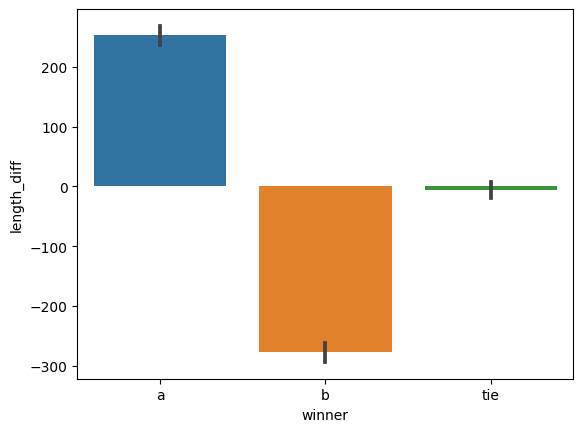

In [17]:
sns.barplot(df_train, x='winner', y='length_diff')
plt.show()

In [18]:
label_dict = {'a': 0, 'b': 1, 'tie': 2}
df_train['winner'].replace(label_dict, inplace=True)
df_train.drop(['id'], axis=1, inplace=True)
train_data, val_data = train_test_split(df_train, random_state=42, train_size=0.7)

/tmp/ipykernel_24/3306986661.py:3: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_24/3306986661.py:3: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



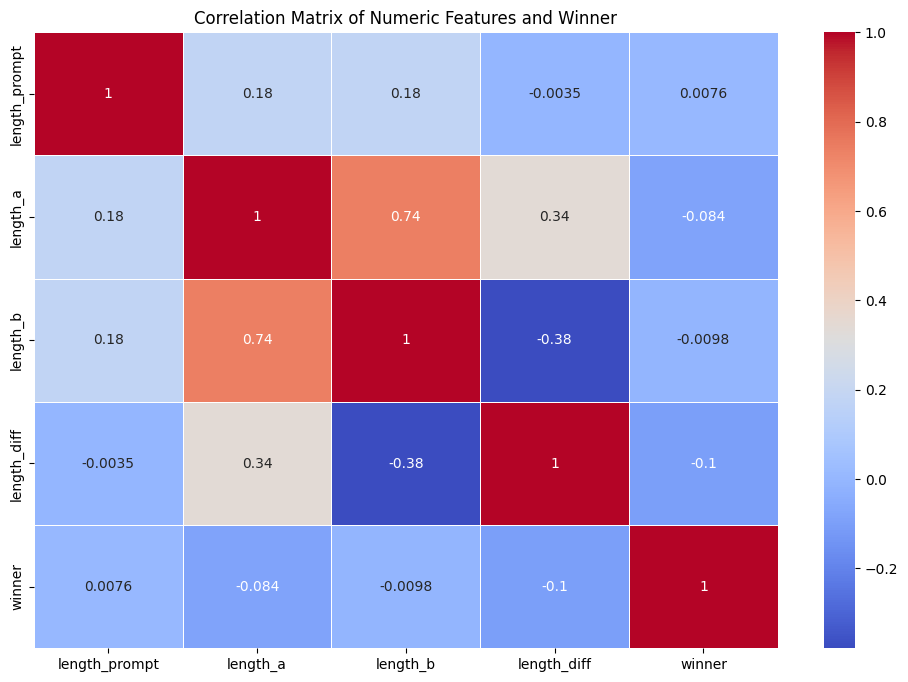

In [19]:
correlation_matrix = df_train[['length_prompt', 'length_a', 'length_b', 'length_diff', 'winner']].corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numeric Features and Winner')
plt.show()

In [20]:
def set_seed(seed=CONFIG['seed']):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()

# Dataset, DataLoader and Model

In [21]:
tokenizer = AutoTokenizer.from_pretrained(CONFIG['pretrained_model_path'])

/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:550: UserWarning:

The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.



In [22]:
# 文章の前処理(トークンの長さを調整)

def text_length(df):
    # prompt
    print(f'== prompt ==')
    prompt_new = []
    tk0 = tqdm(df['prompt'].fillna("").values, total=len(df))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        if length > 128:  
            text = tokenizer.convert_tokens_to_string(tokenizer.tokenize(text)[:64] + tokenizer.tokenize(text)[-64:])  
        prompt_new.append(text)

    # response_a
    print(f'== response_a ==')
    response_a_new = []
    tk0 = tqdm(df['response_a'].fillna("").values, total=len(df))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        if length > 256:  
            text = tokenizer.convert_tokens_to_string(tokenizer.tokenize(text)[:128] + tokenizer.tokenize(text)[-128:]) 
            #text = tokenizer.convert_tokens_to_string(tokenizer.tokenize(text)[:256] + tokenizer.tokenize(text)[-256:])  
        response_a_new.append(text)

    # response_b
    print(f'== response_b ==')
    response_b_new = []
    tk0 = tqdm(df['response_b'].fillna("").values, total=len(df))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        if length > 256:  
            text = tokenizer.convert_tokens_to_string(tokenizer.tokenize(text)[:128] + tokenizer.tokenize(text)[-128:])
            #text = tokenizer.convert_tokens_to_string(tokenizer.tokenize(text)[:256] + tokenizer.tokenize(text)[-256:])
        response_b_new.append(text)

    return prompt_new, response_a_new, response_b_new

In [23]:
df_train['prompt'], df_train['response_a'], df_train['response_b'] = text_length(df_train)
df_test['prompt'], df_test['response_a'], df_test['response_b'] = text_length(df_test)

== prompt ==


100%|██████████| 57477/57477 [00:41<00:00, 1398.94it/s]


== response_a ==


100%|██████████| 57477/57477 [02:39<00:00, 360.89it/s]


== response_b ==


100%|██████████| 57477/57477 [02:44<00:00, 348.87it/s]


== prompt ==


100%|██████████| 3/3 [00:00<00:00, 2248.15it/s]


== response_a ==


100%|██████████| 3/3 [00:00<00:00, 234.30it/s]


== response_b ==


100%|██████████| 3/3 [00:00<00:00, 299.90it/s]


In [24]:
class CustomDataset(Dataset):
    def __init__(self, tokenizer, prompt, response_a, response_b, full_text, winner):
        self.prompt = prompt
        self.response_a = response_a
        self.response_b = response_b
        self.full_text = full_text
        self.target = winner
        self.tokenizer = tokenizer
    
    def __len__(self):
        return len(self.full_text)
    
    def __getitem__(self, idx):
        # prompt
        tokenized_prompt = self.tokenizer.encode_plus(
                            self.prompt[idx],
                            return_token_type_ids=False,
                            return_attention_mask=True,
                            max_length=128,  
                            truncation=True,
                            padding='max_length',
                            add_special_tokens=True,
                            return_tensors='pt'
                        )
        # response_a
        tokenized_response_a = self.tokenizer.encode_plus(
                            self.response_a[idx],
                            return_token_type_ids=False,
                            return_attention_mask=True,
                            max_length=256,  
                            truncation=True,
                            padding='max_length',
                            add_special_tokens=True,
                            return_tensors='pt'
                        )
        # response_b
        tokenized_response_b = self.tokenizer.encode_plus(
                            self.response_b[idx],
                            return_token_type_ids=False,
                            return_attention_mask=True,
                            max_length=256, 
                            truncation=True,
                            padding='max_length',
                            add_special_tokens=True,
                            return_tensors='pt'
                        )
        return {
            'prompt_input_ids': tokenized_prompt['input_ids'].flatten(),
            'prompt_attention_mask': tokenized_prompt['attention_mask'].flatten(),
            'response_a_input_ids': tokenized_response_a['input_ids'].flatten(),
            'response_a_attention_mask': tokenized_response_a['attention_mask'].flatten(),
            'response_b_input_ids': tokenized_response_b['input_ids'].flatten(),
            'response_b_attention_mask': tokenized_response_b['attention_mask'].flatten(),
            'target': self.target[idx]
        }

In [25]:
train_dataset = CustomDataset(tokenizer, 
                              train_data['prompt'].values,
                              train_data['response_a'].values, 
                              train_data['response_b'].values, 
                              train_data['full_text'].values,
                              train_data['winner'].values)
val_dataset = CustomDataset(tokenizer, 
                            val_data['prompt'].values,
                            val_data['response_a'].values, 
                            val_data['response_b'].values, 
                            val_data['full_text'].values,
                            val_data['winner'].values)
train_dataloader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False, pin_memory=True)

next(iter(train_dataloader))

{'prompt_input_ids': tensor([[  1, 647, 309,  ...,   0,   0,   0],
         [  1, 647, 309,  ...,   0,   0,   0],
         [  1, 647, 309,  ...,   0,   0,   0],
         ...,
         [  1, 647, 309,  ...,   0,   0,   0],
         [  1, 647, 309,  ...,   0,   0,   0],
         [  1, 647, 309,  ...,   0,   0,   0]]),
 'prompt_attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'response_a_input_ids': tensor([[    1,   647,   309,  ...,     0,     0,     0],
         [    1,   647,   309,  ...,   673, 36833,     2],
         [    1,   647,   309,  ...,   263,  1010,     2],
         ...,
         [    1,   647,   309,  ...,     0,     0,     0],
         [    1,   647,   309,  ...,     0,     0,     0],
         [    1,   647,   309,  ...,     0,     0,     0]]),
 'response_a_attention_mask': tensor(

In [26]:
class MeanPoolingLayer(nn.Module):
    def __init__(self):
        super(MeanPoolingLayer, self).__init__()
    
    def forward(self, last_hidden_state, attention_mask):
        expanded_mask = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        mask_sum = expanded_mask.sum(1)
        mask_sum = torch.clamp(mask_sum, min=1e-9)
        masked_hidden_state = torch.sum(last_hidden_state * expanded_mask, 1)
        return masked_hidden_state / mask_sum

In [27]:
class CustomModel(nn.Module):
    def __init__(self, num_classes=3):
        super(CustomModel, self).__init__()
        self.pretrained_layer = AutoModel.from_pretrained(CONFIG['pretrained_model_path'])
        self.pooler = MeanPoolingLayer()
        self.dropout = nn.Dropout(p=0.3)
        hidden_size = self.pretrained_layer.config.hidden_size
        self.fc = nn.Linear(6 * hidden_size, num_classes)  
    
    def forward(self, prompt_input_ids, prompt_attention_mask, response_a_input_ids, response_a_attention_mask, response_b_input_ids, response_b_attention_mask):
        # prompt
        prompt_out = self.pretrained_layer(input_ids=prompt_input_ids, attention_mask=prompt_attention_mask)
        prompt_emb = self.pooler(prompt_out.last_hidden_state, prompt_attention_mask)
        # response_a
        response_a_out = self.pretrained_layer(input_ids=response_a_input_ids, attention_mask=response_a_attention_mask)
        response_a_emb = self.pooler(response_a_out.last_hidden_state, response_a_attention_mask)
        # response_b
        response_b_out = self.pretrained_layer(input_ids=response_b_input_ids, attention_mask=response_b_attention_mask)
        response_b_emb = self.pooler(response_b_out.last_hidden_state, response_b_attention_mask)
        # concat
        concat_emb = torch.cat([prompt_emb, response_a_emb, torch.abs(response_a_emb - prompt_emb), response_b_emb, torch.abs(response_b_emb - prompt_emb), torch.abs(response_b_emb - response_a_emb)], dim=-1)
        x = self.dropout(concat_emb)
        x = self.fc(x)
        return x

In [28]:
model = CustomModel().to(CONFIG['device'])
optimizer = AdamW(model.parameters(), lr=CONFIG['lr'], weight_decay=CONFIG['weight_decay'])
loss_fn = nn.CrossEntropyLoss().to(CONFIG['device'])

def eval_metric(ground_truths, probs):
    logloss = 0
    for i in range(len(ground_truths)):
        logloss += np.log(probs[i][ground_truths[i]].item())
    
    return (-1/len(ground_truths)) * logloss

In [29]:
def train_loop(model, dataloader, loss_fn, optimizer):
    model.train()
    batch_losses = []
    scaler = torch.cuda.amp.GradScaler()
    for batch_num, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        prompt_input_ids = batch['prompt_input_ids'].to(CONFIG['device'], non_blocking=True)
        prompt_attention_mask = batch['prompt_attention_mask'].to(CONFIG['device'], non_blocking=True)
        response_a_input_ids = batch['response_a_input_ids'].to(CONFIG['device'], non_blocking=True)
        response_a_attention_mask = batch['response_a_attention_mask'].to(CONFIG['device'], non_blocking=True)
        response_b_input_ids = batch['response_b_input_ids'].to(CONFIG['device'], non_blocking=True)
        response_b_attention_mask = batch['response_b_attention_mask'].to(CONFIG['device'], non_blocking=True)
        targets = batch['target'].to(CONFIG['device'], non_blocking=True)
        
        with torch.cuda.amp.autocast():
            logits = model(prompt_input_ids, prompt_attention_mask, response_a_input_ids, response_a_attention_mask, response_b_input_ids, response_b_attention_mask)
            probs = nn.Softmax(dim=1)(logits)
        batch_loss = loss_fn(logits, targets)
        batch_loss = batch_loss / CONFIG['n_accumulate']
        batch_losses.append(batch_loss.item())
        
        scaler.scale(batch_loss).backward()
        if (batch_num + 1) % CONFIG['n_accumulate'] == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
    
    return np.mean(batch_losses)

In [30]:
def validation_loop(model, loss_fn, dataloader):
    model.eval()
    batch_losses = []
    all_probs = []  
    with torch.no_grad():
        for batch in tqdm(dataloader):
            prompt_input_ids = batch['prompt_input_ids'].to(CONFIG['device'], non_blocking=True)
            prompt_attention_mask = batch['prompt_attention_mask'].to(CONFIG['device'], non_blocking=True)
            response_a_input_ids = batch['response_a_input_ids'].to(CONFIG['device'], non_blocking=True)
            response_a_attention_mask = batch['response_a_attention_mask'].to(CONFIG['device'], non_blocking=True)
            response_b_input_ids = batch['response_b_input_ids'].to(CONFIG['device'], non_blocking=True)
            response_b_attention_mask = batch['response_b_attention_mask'].to(CONFIG['device'], non_blocking=True)
            targets = batch['target'].to(CONFIG['device'], non_blocking=True)
            
            with torch.cuda.amp.autocast():
                logits = model(
                    prompt_input_ids, prompt_attention_mask,
                    response_a_input_ids, response_a_attention_mask,
                    response_b_input_ids, response_b_attention_mask
                )
                probs = nn.Softmax(dim=1)(logits)
                all_probs.append(probs.cpu().numpy()) 
            batch_loss = loss_fn(logits, targets)
            batch_losses.append(batch_loss.item())
    
    return np.mean(batch_losses), all_probs  

In [31]:
history = defaultdict(list)
best_loss = np.inf
prev_loss = np.inf
earlystop_trigger = 0
epochs = CONFIG['epochs']
print('Training Start ......')

for epoch in range(epochs):
    print(f'Epoch {epoch+1} of {epochs}')
    
    train_loss = train_loop(model, train_dataloader, loss_fn, optimizer)
    print(f'Training Loss: {train_loss}')
    
    val_loss, all_probs = validation_loop(model, loss_fn, val_dataloader)
    print(f'Val Loss: {val_loss}')
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_probs'].append(all_probs)  
    
    if val_loss <= prev_loss:
        earlystop_trigger = 0
    else:
        earlystop_trigger += 1
        if earlystop_trigger >= CONFIG['patience']:
            print(f'Early Stopping Triggered after {epoch+1} epochs. Aborting Training...')
            break
    
    if val_loss < best_loss:
        print(f'New best val loss, saving model checkpoint at epoch {epoch+1}.')
        torch.save(model.state_dict(), CONFIG['saved_model_path'])
        best_loss = val_loss
    
    prev_loss = val_loss

Training Start ......
Epoch 1 of 5


100%|██████████| 5030/5030 [56:53<00:00,  1.47it/s]


Training Loss: 0.1331388985423397


100%|██████████| 2156/2156 [08:43<00:00,  4.12it/s]


Val Loss: 1.0299418773191094
New best val loss, saving model checkpoint at epoch 1.
Epoch 2 of 5


100%|██████████| 5030/5030 [56:53<00:00,  1.47it/s]


Training Loss: 0.12748990675090086


100%|██████████| 2156/2156 [08:43<00:00,  4.12it/s]


Val Loss: 1.0175715572095316
New best val loss, saving model checkpoint at epoch 2.
Epoch 3 of 5


100%|██████████| 5030/5030 [56:54<00:00,  1.47it/s]


Training Loss: 0.1208952583328156


100%|██████████| 2156/2156 [08:52<00:00,  4.05it/s]


Val Loss: 1.0181044541396105
Epoch 4 of 5


100%|██████████| 5030/5030 [56:50<00:00,  1.47it/s]


Training Loss: 0.10662441367420478


100%|██████████| 2156/2156 [08:46<00:00,  4.10it/s]


Val Loss: 1.0735959422831634
Epoch 5 of 5


100%|██████████| 5030/5030 [56:53<00:00,  1.47it/s]


Training Loss: 0.08129476922643825


100%|██████████| 2156/2156 [08:42<00:00,  4.13it/s]

Val Loss: 1.2786600258000929
Early Stopping Triggered after 5 epochs. Aborting Training...


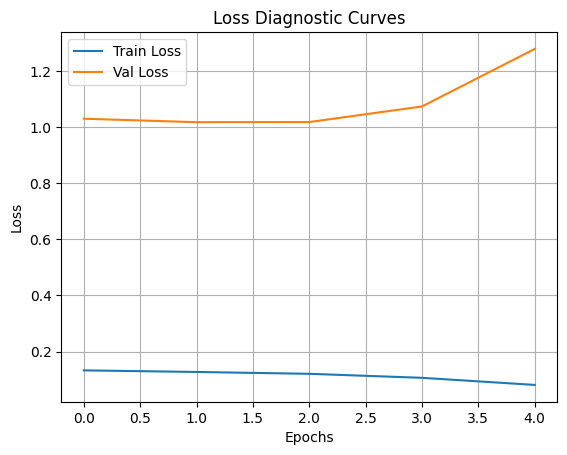

In [32]:
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Diagnostic Curves')
plt.show()

In [33]:
@torch.no_grad()
def inference(prompt, response_a, response_b, model):
    model.eval()
    tokenized_prompt = tokenizer.encode_plus(
        prompt,
        return_token_type_ids=False,
        return_attention_mask=True,
        max_length=128,
        truncation=True,
        padding='max_length',
        add_special_tokens=True,
        return_tensors='pt'
    )
    tokenized_response_a = tokenizer.encode_plus(
                            response_a,
                            return_token_type_ids=False,
                            return_attention_mask=True,
                            max_length=256,
                            truncation=True,
                            padding='max_length',
                            add_special_tokens=True,
                            return_tensors='pt',
                        )
    tokenized_response_b = tokenizer.encode_plus(
                            response_b,
                            return_token_type_ids=False,
                            return_attention_mask=True,
                            max_length=256,
                            truncation=True,
                            padding='max_length',
                            add_special_tokens=True,
                            return_tensors='pt',
                        )
    prompt_input_ids = tokenized_prompt['input_ids'].to(CONFIG['device'], non_blocking=True)
    prompt_attention_mask = tokenized_prompt['attention_mask'].to(CONFIG['device'], non_blocking=True)
    response_a_input_ids = tokenized_response_a['input_ids'].to(CONFIG['device'], non_blocking=True)
    response_a_attention_mask = tokenized_response_a['attention_mask'].to(CONFIG['device'], non_blocking=True)
    response_b_input_ids = tokenized_response_b['input_ids'].to(CONFIG['device'], non_blocking=True)
    response_b_attention_mask = tokenized_response_b['attention_mask'].to(CONFIG['device'], non_blocking=True)
    with torch.cuda.amp.autocast():
        logits = model(prompt_input_ids, prompt_attention_mask, response_a_input_ids, response_a_attention_mask, response_b_input_ids, response_b_attention_mask)
        probs = nn.Softmax(dim=1)(logits)
    return probs

In [34]:
tokenizer = AutoTokenizer.from_pretrained(CONFIG['pretrained_model_path'])

In [35]:
df = pd.DataFrame()
df['id'] = df_test['id']
class0, class1, class2 = [], [], []
model = CustomModel().to(CONFIG['device'])
model.load_state_dict(torch.load(CONFIG['saved_model_path']))
for prompt, response_a, response_b in zip(df_test['prompt'].tolist(), df_test['response_a'].tolist(), df_test['response_b'].tolist()):
    probs = inference(prompt, response_a, response_b, model)
    class0.append(probs[0][0].item())
    class1.append(probs[0][1].item())
    class2.append(probs[0][2].item())
    
df['winner_model_a'] = class0
df['winner_model_b'] = class1
df['winner_tie'] = class2
df.to_csv('submission.csv', index=False)
df

,id,winner_model_a,winner_model_b,winner_tie
0,136060,0.145300,0.439971,0.414729
1,211333,0.227177,0.430580,0.342243
2,1233961,0.366287,0.307692,0.326021
